In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import librosa
import librosa.display
import matplotlib.pyplot as plt
from transformers import Wav2Vec2Processor, Wav2Vec2Model, AutoFeatureExtractor, WavLMForXVector
import torch
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Lambda
import tensorflow.keras.backend as K

In [5]:
import os

real_audio_loc = []
real_labels = []
real_audio_folder_destination = "./real/"
real_audio_clips_folder = os.listdir(real_audio_folder_destination)
for real_audio in real_audio_clips_folder:
    real_audio_loc.append(real_audio_folder_destination + real_audio)
    real_labels.append(0)

fake_audio_loc = []
fake_labels = []
fake_audio_folder_destination = "./fake/"
fake_audio_clips_folder = os.listdir(fake_audio_folder_destination)
for fake_audio in fake_audio_clips_folder:
    fake_audio_loc.append(fake_audio_folder_destination + fake_audio)
    fake_labels.append(1)


In [6]:
# Limit to 3500 samples eac1
audio_loc = real_audio_loc + fake_audio_loc
labels = real_labels + fake_labels

# Create dataframe
data = pd.DataFrame(list(zip(audio_loc, labels)), columns=['File Location', 'Labels'])



In [7]:
data.head()

,File Location,Labels
0,./real/0000003b8fd9bc22877135b42b04c49d4860312...,0
1,./real/0000003b8fd9bc22877135b42b04c49d4860312...,0
2,./real/00000da4b2da194ac31f6d1466d2ceb4823bdc2...,0
3,./real/000014a01678b2c8167bd03f3ca29924365d67d...,0
4,./real/00001571d3cdc8e278a27c30ff764e670582981...,0


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['File Location'], labels, stratify=labels, test_size=0.20)

In [6]:
#plotting mel-spectrogram of a sample audio clip

audio=audio_loc[329]
signal, sample_rate = librosa.load(audio, sr=22050,duration=1.5)
hop_length=512
mel_spectogram=librosa.feature.melspectrogram(y=signal,sr=sample_rate,hop_length=hop_length)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

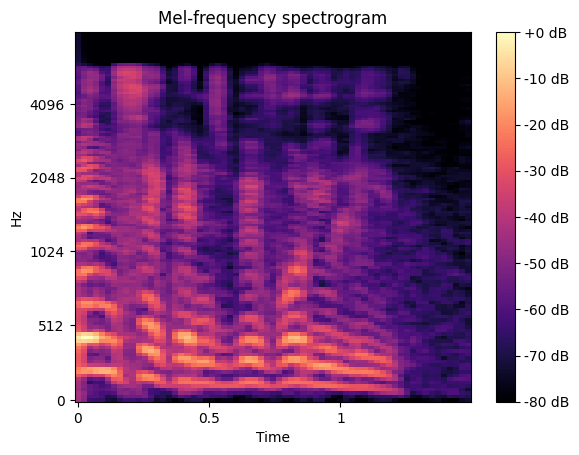

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#Transforming the amplitude to decibel
S_dB = librosa.power_to_db(mel_spectogram, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sample_rate,fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [8]:
import numpy as np
import librosa
from tqdm import tqdm

def mel_spectrogram_gen(audio):
    signal, sample_rate = librosa.load(audio, sr=22050, duration=2)
    hop_length = 512
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, hop_length=hop_length)
    S_dB = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return S_dB

def extract_mel_spectrograms(file_paths):
    mel_spectrograms = []
    for file in tqdm(file_paths):
        mel_spectrogram = mel_spectrogram_gen(file)
        mel_spectrograms.append(mel_spectrogram)
    return mel_spectrograms

X_train_mel = extract_mel_spectrograms(X_train)
X_test_mel = extract_mel_spectrograms(X_test)

def pad_mel_spectrograms(mel_spectrograms, max_pad_len):
    padded_spectrograms = []
    for mel in mel_spectrograms:
        padded_mel = np.pad(mel, ((0, 0), (0, max_pad_len - mel.shape[1])), 'constant', constant_values=0)
        padded_spectrograms.append(padded_mel)
    return np.array(padded_spectrograms)

max_pad_len = max([mel.shape[1] for mel in X_train_mel])
X_train_mel_padded = pad_mel_spectrograms(X_train_mel, max_pad_len)
X_test_mel_padded = pad_mel_spectrograms(X_test_mel, max_pad_len)


100%|██████████| 2354/2354 [00:39<00:00, 59.65it/s]


In [9]:
def normalize_data(data):
    return (data - data.min()) / (data.max() - data.min())

X_train_mel_padded = normalize_data(X_train_mel_padded)
X_test_mel_padded = normalize_data(X_test_mel_padded)

In [10]:
def make_pairs(images, labels):
    pair_images = []
    pair_labels = []
    idx = [np.where(labels == i)[0] for i in np.unique(labels)]
    np.random.seed(85)
    for idxA in range(len(images)):
        current_image = images[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[label])
        pos_image = images[idxB]
        pair_images.append([current_image, pos_image])
        pair_labels.append([1])
        neg_idx = np.where(labels != label)[0]
        neg_image = images[np.random.choice(neg_idx)]
        pair_images.append([current_image, neg_image])
        pair_labels.append([0])
    return np.array(pair_images), np.array(pair_labels)

Pair_train, Label_train = make_pairs(X_train_mel_padded, y_train)
Pair_test, Label_test = make_pairs(X_test_mel_padded, y_test)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Lambda
import tensorflow.keras.backend as K
import tensorflow as tf

def build_siamese_model(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(64, (2, 2), padding="same", activation="relu", kernel_initializer=tf.keras.initializers.he_normal(seed=0))(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)
    x = Conv2D(64, (2, 2), padding="same", activation="relu", kernel_initializer=tf.keras.initializers.he_normal(seed=0))(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.1)(x)
    BatchNorm = tf.keras.layers.BatchNormalization()(x)
    pooledOutput = GlobalAveragePooling2D()(BatchNorm)
    outputs = Dense(embeddingDim)(pooledOutput)
    model = Model(inputs, outputs)
    return model

@tf.keras.utils.register_keras_serializable(package='Custom')
def euclidean_distance(vectors):
    (featsA, featsB) = vectors
    sum_squared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

IMG_SHAPE = (128, max_pad_len, 1)
BATCH_SIZE = 16
EPOCHS = 50

featureExtractor = build_siamese_model(IMG_SHAPE, embeddingDim=48)
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
siamese_model = Model(inputs=[imgA, imgB], outputs=outputs)

In [12]:
checkpoint_filepath = 'siamese_model_checkpoint.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_weights_only=False,  # Save the entire model
    mode='max',
    save_best_only=True
)


In [13]:
checkpoint_filepath = 'siamese_model_checkpoint.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_weights_only=True,  # Save only the weights
    mode='max',
    save_best_only=True
)


In [14]:
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [15]:
with tf.device('/GPU:0'):
    history = siamese_model.fit(
        [Pair_train[:, 0], Pair_train[:, 1]],
        Label_train,
        validation_data=([Pair_test[:, 0], Pair_test[:, 1]], Label_test),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[model_checkpoint_callback,lr_schedule,early_stopping]
    )


Epoch 1/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 100s 84ms/step - accuracy: 0.5131 - loss: 0.7011 - val_accuracy: 0.5348 - val_loss: 0.6879 - learning_rate: 0.0010
Epoch 2/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 98s 83ms/step - accuracy: 0.6103 - loss: 0.6809 - val_accuracy: 0.5760 - val_loss: 0.6606 - learning_rate: 0.0010
Epoch 3/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 110s 94ms/step - accuracy: 0.6679 - loss: 0.6583 - val_accuracy: 0.6170 - val_loss: 0.6533 - learning_rate: 0.0010
Epoch 4/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 116s 98ms/step - accuracy: 0.6893 - loss: 0.6354 - val_accuracy: 0.5896 - val_loss: 0.6520 - learning_rate: 0.0010
Epoch 5/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 117s 99ms/step - accuracy: 0.7026 - loss: 0.6209 - val_accuracy: 0.5888 - val_loss: 0.6714 - learning_rate: 0.0010
Epoch 6/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 115s 98ms/step - accuracy: 0.7110 - loss: 0.6103 - val_accuracy: 0.6415 - val_loss: 0.6294 - learning_rate: 0.0010
Epoch 7/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 117s 99ms/step - 

In [16]:
featureExtractor.save("feature_extractor_model.h5")

In [12]:
def add_noise(signal, noise_factor=0.005):
    noise = np.random.randn(len(signal))
    augmented_signal = signal + noise_factor * noise
    return augmented_signal

In [13]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wave2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

def extract_wave2vec_features(file_paths):
    features = []
    for file in tqdm(file_paths):
        audio_input, _ = librosa.load(file, sr=16000)
        audio_input = add_noise(audio_input)
        inputs = processor(audio_input, sampling_rate=16000, return_tensors="pt", padding=True)
        with torch.no_grad():
            outputs = wave2vec_model(**inputs)
        features.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
    return np.array(features)
with tf.device('/GPU:1'):
  wave2vec_train_features = extract_wave2vec_features(X_train)
  wave2vec_test_features = extract_wave2vec_features(X_test)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 2354/2354 [15:30<00:00,  2.53it/s]


In [14]:
from transformers import AutoFeatureExtractor
from transformers import WavLMForXVector


def pad_audio_to_minimum_length(audio, target_length=16000):
    if len(audio) < target_length:
        padding = target_length - len(audio)
        audio = np.pad(audio, (0, padding), 'constant')
    return audio
device = torch.device('cpu')
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/wavlm-base-plus-sv")



wavlm_model = WavLMForXVector.from_pretrained("microsoft/wavlm-base-plus-sv").to('cpu')

def extract_xvector_features(file_paths):
    features = []
    for file in tqdm(file_paths):
        audio_input, _ = librosa.load(file, sr=16000)
        audio_input = add_noise(audio_input)
        audio_input = pad_audio_to_minimum_length(audio_input)
        inputs = feature_extractor(audio_input, sampling_rate=16000, return_tensors="pt", padding=True)
        inputs = {key: value.to(device) for key, value in inputs.items()}
        with torch.no_grad():
            outputs = wavlm_model(**inputs).embeddings
        features.append(outputs.mean(dim=1).squeeze().cpu().numpy())
    return np.array(features)

with tf.device('/GPU:0'):
    xvector_train_features = extract_xvector_features(X_train)
    xvector_test_features = extract_xvector_features(X_test)

100%|██████████| 2354/2354 [15:09<00:00,  2.59it/s]


In [15]:
def reshape_features(features):
    if features.ndim == 1:
        features = np.expand_dims(features, axis=-1)
    return features.reshape((features.shape[0], -1))
featureExtractor = tf.keras.models.load_model("C://Users//Abdul Kavi Chaudhary//feature_extractor_model.h5", compile=False)

wave2vec_train_features = reshape_features(wave2vec_train_features)
siamese_train_features = reshape_features(featureExtractor.predict(X_train_mel_padded))
xvector_train_features = reshape_features(xvector_train_features)

wave2vec_test_features = reshape_features(wave2vec_test_features)
siamese_test_features = reshape_features(featureExtractor.predict(X_test_mel_padded))
xvector_test_features = reshape_features(xvector_test_features)

train_features = np.concatenate([wave2vec_train_features, siamese_train_features, xvector_train_features], axis=1)
test_features = np.concatenate([wave2vec_test_features, siamese_test_features,xvector_test_features], axis=1)


295/295 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [17]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

classifier_input = Input(shape=(train_features.shape[1],))
dense_1 = Dense(units=64, activation='relu')(classifier_input)
dense_2 = Dense(units=32, activation='relu')(dense_1)
classifier_output = Dense(1, activation='sigmoid')(dense_2)
ensemble_classifier_model = Model(inputs=classifier_input, outputs=classifier_output)

ensemble_classifier_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

with tf.device('/GPU:0'):
    ensemble_classifier_model.fit(train_features, np.array(y_train), epochs=100, batch_size=64, validation_data=(test_features, np.array(y_test)), callbacks=[lr_schedule, early_stopping])


Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9092 - loss: 0.2319 - val_accuracy: 0.9715 - val_loss: 0.0865 - learning_rate: 0.0010
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9731 - loss: 0.0788 - val_accuracy: 0.9749 - val_loss: 0.0636 - learning_rate: 0.0010
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9721 - loss: 0.0779 - val_accuracy: 0.9758 - val_loss: 0.0623 - learning_rate: 0.0010
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9740 - loss: 0.0697 - val_accuracy: 0.9792 - val_loss: 0.0642 - learning_rate: 0.0010
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9724 - loss: 0.0749 - val_accuracy: 0.9745 - val_loss: 0.0644 - learning_rate: 0.0010
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9754 - loss: 0.0750 - val_accuracy: 0.9788 - val_loss: 0.0620 - learning_rate: 0.0010
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9745 - loss: 0.

In [18]:
# Define the file path for saving the entire ensemble model
ensemble_model_filepath = 'wave_ensemble_classifier.keras'

ensemble_classifier_model.save(ensemble_model_filepath)


In [7]:
import librosa
import numpy as np
import torch
import tensorflow as tf
from transformers import Wav2Vec2Processor, Wav2Vec2Model, AutoFeatureExtractor, WavLMForXVector
import os


def pad_audio_to_minimum_length(audio, target_length=16000):
    if len(audio) < target_length:
        padding = target_length - len(audio)
        audio = np.pad(audio, (0, padding), 'constant')
    return audio


# Load models
wave2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-large-960h")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
wavlm_model = WavLMForXVector.from_pretrained("microsoft/wavlm-large")
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/wavlm-large")
siamese_model = tf.keras.models.load_model("feature_extractor_model.h5", compile=False)
ensemble_classifier_model = tf.keras.models.load_model('ensemble_classifier.keras')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move models to GPU
wave2vec_model.to(device)
wavlm_model.to(device)

# Helper function to extract mel spectrogram
def mel_spectrogram_gen(audio):
    signal, sample_rate = librosa.load(audio, sr=22050, duration=2)
    hop_length = 512
    n_mels = 128
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, hop_length=hop_length, n_mels=n_mels)
    S_dB = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return S_dB

# Helper function to pad mel spectrograms
def pad_mel_spectrograms(mel_spectrogram, max_pad_len=87):
    pad_width = max_pad_len - mel_spectrogram.shape[1]
    if pad_width > 0:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_pad_len]
    return mel_spectrogram

# Function to extract Wav2Vec2 features
def extract_wave2vec_features(audio_file):
    audio_input, _ = librosa.load(audio_file, sr=16000)
    inputs = processor(audio_input, sampling_rate=16000, return_tensors="pt", padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to device
    with torch.no_grad():
        outputs = wave2vec_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# Function to extract WavLM features
def extract_xvector_features(audio_file):
    audio_input, _ = librosa.load(audio_file, sr=16000)
    inputs = feature_extractor(audio_input, sampling_rate=16000, return_tensors="pt", padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to device
    with torch.no_grad():
        outputs = wavlm_model(**inputs).embeddings
    return outputs.mean(dim=1).squeeze().cpu().numpy()

# Function to normalize data
def normalize_data(data):
    return (data - data.min()) / (data.max() - data.min())

def get_audio_duration(audio_file):
    signal, sr = librosa.load(audio_file, sr=None)  # Load with original sample rate
    duration = len(signal) / sr
    return duration

# Main inference function
def predict_audio(audio_file):
    duration = get_audio_duration(audio_file)
    # Mel-spectrogram extraction and padding
    mel_spectrogram = mel_spectrogram_gen(audio_file)
    max_pad_len = 87  # Ensure this matches the value used in training
    mel_spectrogram_padded = pad_mel_spectrograms(mel_spectrogram, max_pad_len)
    mel_spectrogram_padded = normalize_data(mel_spectrogram_padded)
    
    # Adjust shape to match model input
    mel_spectrogram_padded = np.expand_dims(mel_spectrogram_padded, axis=-1)  # Shape: (128, 87, 1)
    mel_spectrogram_padded = np.expand_dims(mel_spectrogram_padded, axis=0)   # Shape: (1, 128, 87, 1)

    # Feature extraction
    wave2vec_features = extract_wave2vec_features(audio_file)
    xvector_features = extract_xvector_features(audio_file)
    siamese_features = siamese_model.predict(mel_spectrogram_padded)

    # Reshape features
    wave2vec_features = wave2vec_features.reshape((1, -1))
    siamese_features = siamese_features.reshape((1, -1))
    xvector_features = xvector_features.reshape((1, -1))

    # Concatenate features for ensemble classifier
    combined_features = np.concatenate([wave2vec_features, siamese_features, xvector_features], axis=1)

    # Predict using ensemble classifier
    prediction = ensemble_classifier_model.predict(combined_features)

    # Convert prediction to percentage
    percentage = prediction[0][0] * 100  # Get the first value as a percentage
    print(f"Prediction probability: {percentage:.2f}% fake")

    # Output result
    if prediction[0][0] >= 0.5:  # Using the probability threshold
        return ("Fake Audio",duration)
    else:
        return ("Real Audio",duration)
    
    
def predict_audio_batch(folder_path):
    results = []
    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith(('.wav', '.mp3', '.m4a', '.flac')):  # Supported audio formats
            audio_file = os.path.join(folder_path, file_name)
            try:
                result = predict_audio(audio_file)
                results.append((file_name, result))
                print(f"{file_name}: {result}")
            except Exception as e:
                print(f"Error processing {file_name}: {e}")
    return results


# Example usage
audio_folder = "C:\\Users\\Abdul Kavi Chaudhary\\Desktop\\Test\\real"
result = predict_audio_batch(audio_folder)


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of WavLMForXVector were not initialized from the model checkpoint at microsoft/wavlm-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'feature_extractor.bias', 'feature_extractor.weight', 'objective.weight', 'projector.bias', 'projector.weight', 'tdnn.0.kernel.bias', 'tdnn.0.kernel.weight', 'tdnn.1.kernel.bias', 'tdnn.1.kernel.weight', 'tdnn.2.kernel.bias', 'tdnn.2.kernel.weight', 'tdnn.3.kernel.bias', 'tdnn.3.kernel.weight', 'tdnn.4.kernel.bias', 'tdnn.4.kernel.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

c:\Users\Abdul Kavi Chaudhary\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction probability: 0.11% fake
00000682f31904acc560fa359512e7bdd487b11efe36145a56874e30_16k_mono.wav: ('Real Audio', 7.71)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Prediction probability: 0.52% fake
0000068bfcd8e252fd9ec8225bd1fdb47378a009f8afa00d4e998df5_16k_mono.wav: ('Real Audio', 14.589)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Prediction probability: 1.56% fake
000009ed98ed39118493c10c8cf25ec9a6a936bd6cc6e527c29dccec_16k_mono.wav: ('Real Audio', 10.351)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Prediction probability: 56.86% fake
00000e944e581a66136c69bc1f89b8a1dd5f70a87fd39b1ea23cf0d1_16k_mono.wav: ('Fake Audio', 8.959)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Prediction probability: 17.01% fake
0000187289951616e63a258bed0d0e6c83e83c0ebd7587de8b85185a_16k_mono.wav: ('Real Audio', 9.099)
1/1 ━━━━━━━━━━━━

In [8]:
count = 0
for i in result:
        if 'Fake Audio' in i[1]:
                count += 1
print(count)
        


51


In [25]:
import os
import random
import shutil

# Paths for the source and destination folders
source_folder = "C:\\Users\\Abdul Kavi Chaudhary\\Desktop\\Merged_Dataset\\fake"
destination_folder = "C:\\Users\\Abdul Kavi Chaudhary\\Desktop\\Test\\fake"

# Ensure the destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# List all audio files in the source folder
# Adjust the extensions as per your file types (e.g., .mp3, .wav, .flac, etc.)
audio_extensions = (".mp3", ".wav", ".flac", ".ogg", ".aac")  
audio_files = [f for f in os.listdir(source_folder) if f.lower().endswith(audio_extensions)]

# Check if there are at least 100 files to move
if len(audio_files) < 100:
    print(f"Not enough files to move. Found only {len(audio_files)} files.")
else:
    # Randomly select 100 files
    selected_files = random.sample(audio_files, 100)

    # Move each file to the destination folder
    for file_name in selected_files:
        src_path = os.path.join(source_folder, file_name)
        dest_path = os.path.join(destination_folder, file_name)
        shutil.move(src_path, dest_path)

    print(f"Successfully moved 100 files to {destination_folder}.")


Not enough files to move. Found only 0 files.
